# Contextual bandit with changing context part 2
> Customizing the context and changing it midway to see how fast the agent can adapt to the new context and start recommending better products as per the context

- toc: true
- badges: true
- comments: true
- categories: [contextual bandit]
- image: 

In [ ]:
mapping_users = {
    'Alex':'usera',
    'Ben':'userb',
    'Cindy': 'userc'
}
    
mapping_context1 = {
    'Morning':'ctx11',
    'Evening':'ctx12',
}

mapping_context2 = {
    'Summer':'ctx21',
    'Winter':'ctx22'
}

mapping_items = {
    'Politics':'item1',
    'Economics':'item2',
    'Technology':'item3',
    'Movies':'item4',
    'Business':'item5',
    'History':'item6'
}

# {v:k for k,v in mappings.items()}

In [ ]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

In [ ]:
users = list(mapping_users.values())
items = list(mapping_items.values())
context1 = list(mapping_context1.values())
context2 = list(mapping_context2.values())

In [ ]:
context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = np.random.choice([0,1],len(context))
context['cost'] = context['reward']*-1
contextdf = context.copy()

In [ ]:
contextdf

,users,context1,context2,items,reward,cost
0,usera,ctx11,ctx21,item1,1,-1
1,usera,ctx11,ctx21,item2,1,-1
2,usera,ctx11,ctx21,item3,1,-1
3,usera,ctx11,ctx21,item4,0,0
4,usera,ctx11,ctx21,item5,0,0
...,...,...,...,...,...,...
67,userc,ctx12,ctx22,item2,0,0
68,userc,ctx12,ctx22,item3,0,0
69,userc,ctx12,ctx22,item4,1,-1
70,userc,ctx12,ctx22,item5,1,-1


In [ ]:
import numpy as np
import scipy
import scipy.stats as stats
from vowpalwabbit import pyvw
import random
import pandas as pd
from itertools import product

In [ ]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User users={} context1={} context2={}\n".format(context["user"], context["context1"], context["context2"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action items={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob
def choose_user(users):
    return random.choice(users)
def choose_context1(context1):
    return random.choice(context1)
def choose_context2(context2):
    return random.choice(context2)

In [ ]:
class VWCSimulation():
    def __init__(self, vw, ictxt, n=100000):
        self.vw = vw
        self.users = ictxt['users'].unique().tolist()
        self.contexts1 = ictxt['context1'].unique().tolist()
        self.contexts2 = ictxt['context2'].unique().tolist()
        self.actions = ictxt['items'].unique().tolist()
        self.contextdf = ictxt.copy()
        self.contextdf['cost'] = self.contextdf['reward']*-1
        
    def get_cost(self, context, action):
        return self.contextdf.loc[(self.contextdf['users']==context['user']) & \
                (self.contextdf.context1==context['context1']) & \
                (self.contextdf.context2==context['context2']) & \
                (self.contextdf['items']==action), \
                'cost'].values[0]
    
    def update_context(self, new_ctxt):
        self.contextdf = new_ctxt.copy()
        self.contextdf['cost'] = self.contextdf['reward']*-1
    
    def step(self):
        user = choose_user(self.users)
        context1 = choose_context1(self.contexts1)
        context2 = choose_context2(self.contexts2)
        context = {'user': user, 'context1': context1, 'context2': context2}
        action, prob = get_action(self.vw, context, self.actions)
        cost = self.get_cost(context, action)
        vw_format = self.vw.parse(to_vw_example_format(context, self.actions, (action, cost, prob)), pyvw.vw.lContextualBandit)
        self.vw.learn(vw_format)
        self.vw.finish_example(vw_format)
        return (context['user'], context['context1'], context['context2'], action, cost, prob)

In [ ]:
context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = np.random.choice([0,1],len(context),p=[0.8,0.2])
contextdf = context.copy()
contextdf.reward.value_counts()

0    61
1    11
Name: reward, dtype: int64

In [ ]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
vws = VWCSimulation(vw, contextdf)

In [ ]:
vws.step()

('usera', 'ctx11', 'ctx22', 'item4', 0, 0.16666666666666666)

In [ ]:
_temp = []
for i in range(5000):
    _temp.append(vws.step())

In [ ]:
x = pd.DataFrame.from_records(_temp, columns=['user','context1','context2','item','cost','prob'])

In [ ]:
xx = x.copy()
xx['ccost'] = xx['cost'].cumsum()
xx = xx.fillna(0)
xx = xx.rename_axis('iter').reset_index()
xx['ctr'] = -1*xx['ccost']/xx['iter']
xx.sample(10)

,iter,user,context1,context2,item,cost,prob,ccost,ctr
3199,3199,usera,ctx11,ctx22,item5,-1,0.833333,-1781,0.556736
700,700,userb,ctx11,ctx22,item4,-1,0.833333,-343,0.490000
3660,3660,usera,ctx12,ctx22,item5,0,0.833333,-2035,0.556011
4123,4123,userc,ctx12,ctx22,item5,-1,0.833333,-2302,0.558331
4448,4448,userb,ctx11,ctx22,item4,-1,0.833333,-2480,0.557554
485,485,usera,ctx11,ctx21,item2,-1,0.833333,-219,0.451546
3280,3280,userb,ctx11,ctx21,item1,0,0.033333,-1822,0.555488
1679,1679,userb,ctx12,ctx21,item6,-1,0.833333,-901,0.536629
3489,3489,userc,ctx11,ctx21,item3,-1,0.833333,-1932,0.553740
103,103,usera,ctx11,ctx22,item2,0,0.833333,-24,0.233010


<AxesSubplot:>

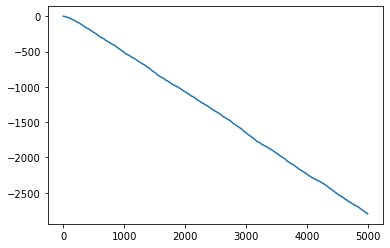

In [ ]:
xx['ccost'].plot()

<AxesSubplot:>

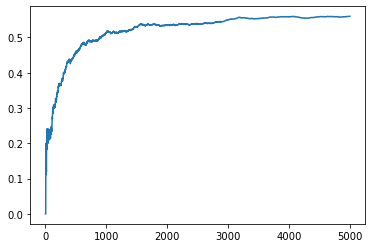

In [ ]:
xx['ctr'].plot()

In [ ]:
tempdf1 = xx.copy()

In [ ]:
context = pd.DataFrame(list(product(users, context1, context2, items)), columns=['users', 'context1', 'context2', 'items'])
context['reward'] = 0
X = context.copy()
X.loc[(X['users']=='usera')&(X['items']=='item1'),'reward']=1
X.loc[(X['users']=='userb')&(X['items']=='item2'),'reward']=1
X.loc[(X['users']=='userc')&(X['items']=='item3'),'reward']=1
X.reward.value_counts()

0    60
1    12
Name: reward, dtype: int64

In [ ]:
vws.update_context(X)

In [ ]:
_temp = []
for i in range(5000):
    _temp.append(vws.step())

In [ ]:
x = pd.DataFrame.from_records(_temp, columns=['user','context1','context2','item','cost','prob'])
xx = x.copy()
xx['ccost'] = xx['cost'].cumsum()
xx = xx.fillna(0)
xx = xx.rename_axis('iter').reset_index()
xx['ctr'] = -1*xx['ccost']/xx['iter']
xx.sample(10)

,iter,user,context1,context2,item,cost,prob,ccost,ctr
354,354,userc,ctx12,ctx21,item2,0,0.833333,-88,0.248588
3362,3362,userb,ctx11,ctx22,item2,-1,0.833333,-2481,0.737954
485,485,usera,ctx11,ctx22,item1,-1,0.833333,-171,0.352577
3383,3383,userb,ctx11,ctx22,item3,0,0.033333,-2499,0.738693
2803,2803,userc,ctx12,ctx21,item3,-1,0.833333,-2002,0.714235
3410,3410,userb,ctx12,ctx21,item3,0,0.033333,-2521,0.739296
267,267,usera,ctx12,ctx21,item4,0,0.033333,-54,0.202247
3848,3848,userb,ctx12,ctx21,item2,-1,0.833333,-2888,0.750520
54,54,userb,ctx12,ctx21,item6,0,0.833333,-13,0.240741
1447,1447,userc,ctx11,ctx21,item5,0,0.033333,-891,0.615757


In [ ]:
tempdf2 = tempdf1.append(xx, ignore_index=True)
tempdf2.sample(10)

,iter,user,context1,context2,item,cost,prob,ccost,ctr
8837,3837,usera,ctx12,ctx22,item1,-1,0.833333,-2879,0.750326
8210,3210,userc,ctx11,ctx21,item2,0,0.033333,-2348,0.731464
3280,3280,userb,ctx11,ctx21,item1,0,0.033333,-1822,0.555488
1029,1029,userc,ctx12,ctx21,item1,0,0.033333,-531,0.516035
4183,4183,userc,ctx12,ctx22,item2,0,0.033333,-2328,0.556538
2715,2715,userc,ctx11,ctx22,item4,-1,0.833333,-1467,0.540331
6300,1300,usera,ctx12,ctx21,item1,-1,0.833333,-776,0.596923
7111,2111,usera,ctx12,ctx21,item1,-1,0.833333,-1427,0.675983
4008,4008,usera,ctx11,ctx22,item5,-1,0.833333,-2239,0.558633
2236,2236,userc,ctx12,ctx21,item2,-1,0.833333,-1203,0.538014


<AxesSubplot:>

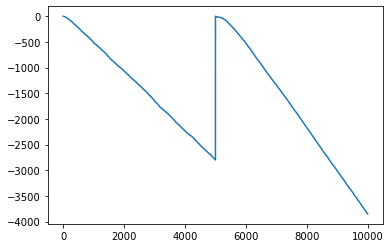

In [ ]:
tempdf2['ccost'].plot()

<AxesSubplot:>

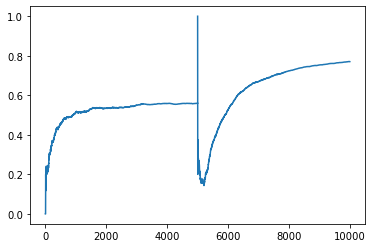

In [ ]:
tempdf2['ctr'].plot()